In [22]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyzer
from mesa.batchrunner import batch_run  
from social_force_model import CrowdModel

In [31]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the dimension of the grid
dimension = 25

# Function to calculate the scaling factor based on the dimension
def scaling_factor(fraction, dimension):
    return int(np.sqrt((fraction * dimension**2)/np.pi))

# Define the Sobol analysis problem
problem = {
    'num_vars': 9,
    'names': ['social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment', 
              'gumbel_plus_mean', 'gumbel_plus_std', 'gumbel_minus_mean', 'gumbel_minus_std'],
    'bounds': [
        [0, scaling_factor(1/6, dimension)],  # Social radius
        [0, dimension],  # Fire radius
        [0, dimension],  # Exit radius
        [0, 1.1],  # Probability of spreading
        [0, 1.1],  # Probability of spreading environment knowledge
        [0.5, 1.6],  # Gumbel plus mean
        [0.25, 1.01],  # Gumbel plus std
        [0.5, 1.01],  # Gumbel minus mean
        [0.25, 1.01]  # Gumbel minus std
    ]
}

# Fixed parameters for the model
fixed_params = {
    "width": dimension,
    "height": dimension,
    "N": int(0.25 * dimension * dimension),  # 25% of the grid size
    "p_env_knowledge_params": [3/25, 17/25],
    "fire_avoidance_radius": 1
}

# Function to adjust exits based on radius
def get_exits_with_radius(dimension, radius):
    return [
        {"location": (dimension // 2, dimension - 1), "radius": radius},  # Main exit
        {"location": (0, 0), "radius": radius},  # Emergency exit 1
        {"location": (dimension - 1, 0), "radius": radius}  # Emergency exit 2
    ]

# Function to run a single batch of simulations
def run_single_batch(param_set, param_dict):
    try:
        pid = os.getpid()
        logging.info(f"Running batch with parameters: {param_set} on PID: {pid}")
        results = batch_run(
            model_cls=CrowdModel,
            parameters=param_dict,
            number_processes=None,  # Use all available processors
            iterations=10,  # Number of iterations per parameter set
            max_steps=700,  # Max steps for each run
            data_collection_period=-1,  # Collect data at each step
            display_progress=False  # Display progress bar
        )
        return results
    except Exception as e:
        logging.error(f"Error during batch_run for {param_set} on PID: {pid}: {e}")
        return None

# Run the sensitivity analysis using Sobol sampling
def run_sobol_sensitivity_analysis(checkpoint_interval=100, checkpoint_file="sobol_checkpoint.csv"):
    # Generate samples
    param_values = sobol.sample(problem, 2)  # Increased sample size for final analysis

    # Load previous checkpoint if exists
    if os.path.exists(checkpoint_file):
        data = pd.read_csv(checkpoint_file)
        start_index = data['RunId'].notnull().sum()
    else:
        start_index = 0
        data = pd.DataFrame(index=range(len(param_values)), 
                            columns=['RunId', 'social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment',
                                     'gumbel_plus_mean', 'gumbel_plus_std', 'gumbel_minus_mean', 'gumbel_minus_std',
                                     'Agents Removed', 'Agents Know Fire', 'Exit Knowledge Spread', 'Change Goal'])

    all_results = []
    
    for i in tqdm(range(start_index, len(param_values)), desc="Running Simulations"):
        vals = param_values[i]
        param_set = {
            "social_radius": int(vals[0]),  # Cast to int explicitly
            "fire_radius": int(vals[1]),  # Cast to int explicitly
            "exits": get_exits_with_radius(dimension, int(vals[2])),  # Ensure correct parameterization
            "p_spreading": vals[3],
            "p_spreading_environment": vals[4],
            "gumbel_params": [vals[5], vals[6], vals[7], vals[8]]
        }

        # Combine with fixed parameters
        param_set.update(fixed_params)
        
        # Convert param_set to a format suitable for batch_run
        param_dict = {k: [v] for k, v in param_set.items() if not isinstance(v, list)}
        param_dict['exits'] = [param_set['exits']]  # Ensure 'exits' is in a list of lists format
        param_dict['p_env_knowledge_params'] = [fixed_params['p_env_knowledge_params']]  # Ensure 'p_env_knowledge_params' is in a list of lists format
        param_dict['gumbel_params'] = [param_set['gumbel_params']]  # Ensure 'gumbel_params' is in a list format
        
        results = run_single_batch(param_set, param_dict)
        if results is not None:
            results_df = pd.DataFrame(results)
            
            # Extract the average of each measure over iterations
            mean_results = results_df[['Agents Removed', 'Agents Know Fire', 'Exit Knowledge Spread', 'Change Goal']].mean(axis=0)
            
            # Store results
            data.iloc[i, 0:10] = [i] + list(param_values[i])  # RunId and parameter values
            data.iloc[i, 10] = mean_results.get('Agents Removed', None)  # Storing 'Agents Removed'
            data.iloc[i, 11] = mean_results.get('Agents Know Fire', None)  # Storing 'Agents Know Fire'
            data.iloc[i, 12] = mean_results.get('Exit Knowledge Spread', None)  # Storing 'Exit Knowledge Spread'
            data.iloc[i, 13] = mean_results.get('Change Goal', None)  # Storing 'Change Goal'

        # Save checkpoint at regular intervals
        if (i + 1) % checkpoint_interval == 0:
            data.to_csv(checkpoint_file, index=False)
            logging.info(f"Checkpoint saved at iteration {i + 1}")

    # Save final results
    data.to_csv(checkpoint_file, index=False)
    return data

In [32]:
# Ensure this code runs only when executed as a script, not when imported as a module
if __name__ == "__main__":
    # Run the Sobol sensitivity analysis and save data
    sobol_results_df = run_sobol_sensitivity_analysis()
    final_file = "sobol_sensitivity_analysis_results.csv"
    sobol_results_df.to_csv(final_file, index=False)
    logging.info(f"Sobol sensitivity analysis completed and results saved to {final_file}!")

Running Simulations: 100%|██████████| 40/40 [15:44<00:00, 23.62s/it]
2024-07-01 15:24:08,815 - INFO - Sobol sensitivity analysis completed and results saved to sobol_sensitivity_analysis_results.csv!


c:\Users\koenw\AppData\Local\Programs\Python\Python312\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Sobol Sensitivity Analysis Results:
First order indices: [ 5.38320985 -0.4205171  -0.05434731 -0.17499062 -0.11426211 -0.09379086
 -0.01940057 -0.03152058 -0.06239876]
Total order indices: [1.26107012e+01 4.33236679e-01 1.94484402e-03 6.19528552e-02
 1.55587522e-02 2.32575130e-02 9.56298952e-03 5.03845602e-04
 5.12914822e-03]
Second order indices: [[        nan -3.44976785 -5.14772753 -4.57850292 -4.90289888 -4.88105213
  -5.10524327 -5.25829141 -5.07847899]
 [        nan         nan -2.03495681 -2.14187284 -2.11998579 -2.001965
  -1.82910565 -2.01714083 -2.01573006]
 [        nan         nan         nan  0.13356947  0.17101527  0.16029344
   0.17534835  0.20662708  0.18494157]
 [        nan         nan         nan         nan  0.1968953   0.18750362
   0.22232943  0.25971477  0.22555404]
 [        nan         nan         nan         nan         nan  0.61357058
   0.60704074  0.67546297  0.64734839]
 [        nan         nan         nan         nan         nan         nan
   0.6229673 

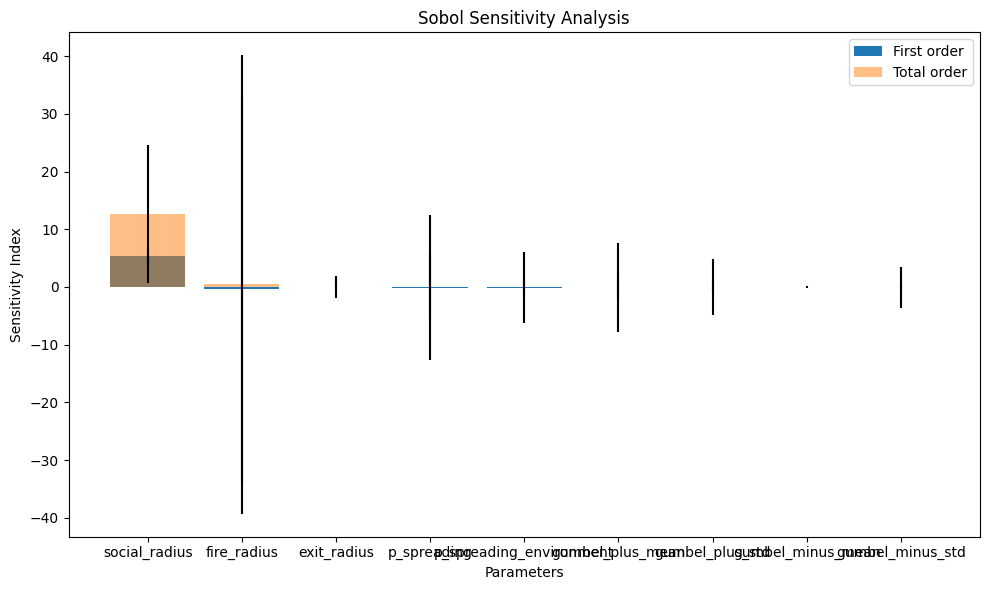

In [33]:
Y = sobol_results_df['Agents Removed'].dropna().values  # Target variable for analysis
Si = sobol_analyzer.analyze(problem, Y, n_processors=4)  # Use 4 processors for parallel processing

# Print Sobol indices
print("Sobol Sensitivity Analysis Results:")
print("First order indices:", Si['S1'])
print("Total order indices:", Si['ST'])
print("Second order indices:", Si['S2'])

# Plot results for quick inspection
plt.figure(figsize=(10, 6))
plt.bar(problem['names'], Si['S1'], yerr=Si['S1_conf'], label='First order')
plt.bar(problem['names'], Si['ST'], yerr=Si['ST_conf'], alpha=0.5, label='Total order')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.title('Sobol Sensitivity Analysis')
plt.legend()
plt.tight_layout()
plt.savefig('sobol_sensitivity_analysis_results.png')
plt.show()